The idea of ​​NBCF is to determine the interest level of a user in an item based on the behavior of other users who are similar to this user. The similarity between users can be determined through the interest level of these users in other items that the system already knows. 

For example, A and B both like the movie Criminal Police, and have both rated this movie 5 stars. We know that A also likes The Judge, so it is likely that B also likes this movie.

There are two main questions in NBCF systems as follows:
1. How do we determine the similarity between users?
2. When we has already defined the similarity between users, how do we determine the interest level of a user in an item?

Determining the interest level of each user into specific items based on the interest level of similar users into these items is called *user-user collaborative filtering*. Another approach that is said to work better is *item-item collaborative filtering*. In this approach, instead of determining similarity between users, the system determines similarity between items. From there, the system suggests items that are similar to items that the user has a high level of interest in.

# User-user collaborative filtering

## Similarity function

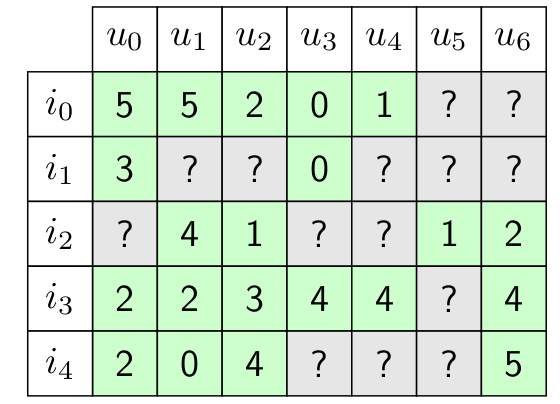

_Figure 1: Utility matrix_

Suppose there are users $u_0$ to $u_6$ and items $i_0$ to $i_4$ where the numbers in each square represent the number of stars each user has rated that item with higher values ​​representing higher interest. The question marks are the values ​​that the system needs to find. Set the similarity of two users $u_i, u_j$ to $\text{sim}(u_i, u_j)$. The first observation that can be noticed is that $u_0, u_1$ like $i_0, i_1, i_2$ and do not like $i_3, i_4$ very much. Therefore, to determine the level of interest of $u_0$ on $i_2$, we should base on the behavior of $u_1$ on this item. Fortunately, $u_1$ already likes $i_2$ so the system needs to recommend $i_2$ to $u_0$.

To measure similarity between two users, the usual way is to build a feature vector for each user and then apply a function that can measure the similarity between the two vectors. Note that building this feature vector is different from building an item profile as in content-based recommendation systems. These vectors are built directly based on the utility matrix without using additional information such as an item profile. For each user, the only information we know is the ratings that the user has made, i.e. the column corresponding to that user in the utility matrix. However, the difficulty is that these columns often have many missing values ​​because each user usually only rates a very small number of items. One solution is to help the system initially estimate these values ​​roughly so that filling in does not greatly affect the similarity between the two vectors. This estimation only serves to calculate similarity, not the final result that the system needs to estimate.

So what value should each $‘?’$ be replaced by to reduce the bias in the estimate? The first option that comes to mind is to replace the $‘?’$ with a value of $0$. This is not very good because $0$ represents the lowest level of interest; and a user who has not rated an item does not mean that they are completely uninterested in the item. A safer value is $2.5$ because it is the average of $0$, the lowest level, and $5$, the highest level. However, this value has limitations for easy-going or difficult-going users. Easy-going users may give three stars to items they do not like, while difficult users may give three stars to items they like. Replacing all missing items with $2.5$ in this case is not effective. A more feasible value for this is to estimate missing items as the average value that a user gives. This helps avoid having a user who is too difficult or too easy. And these estimated values ​​depend on each user.

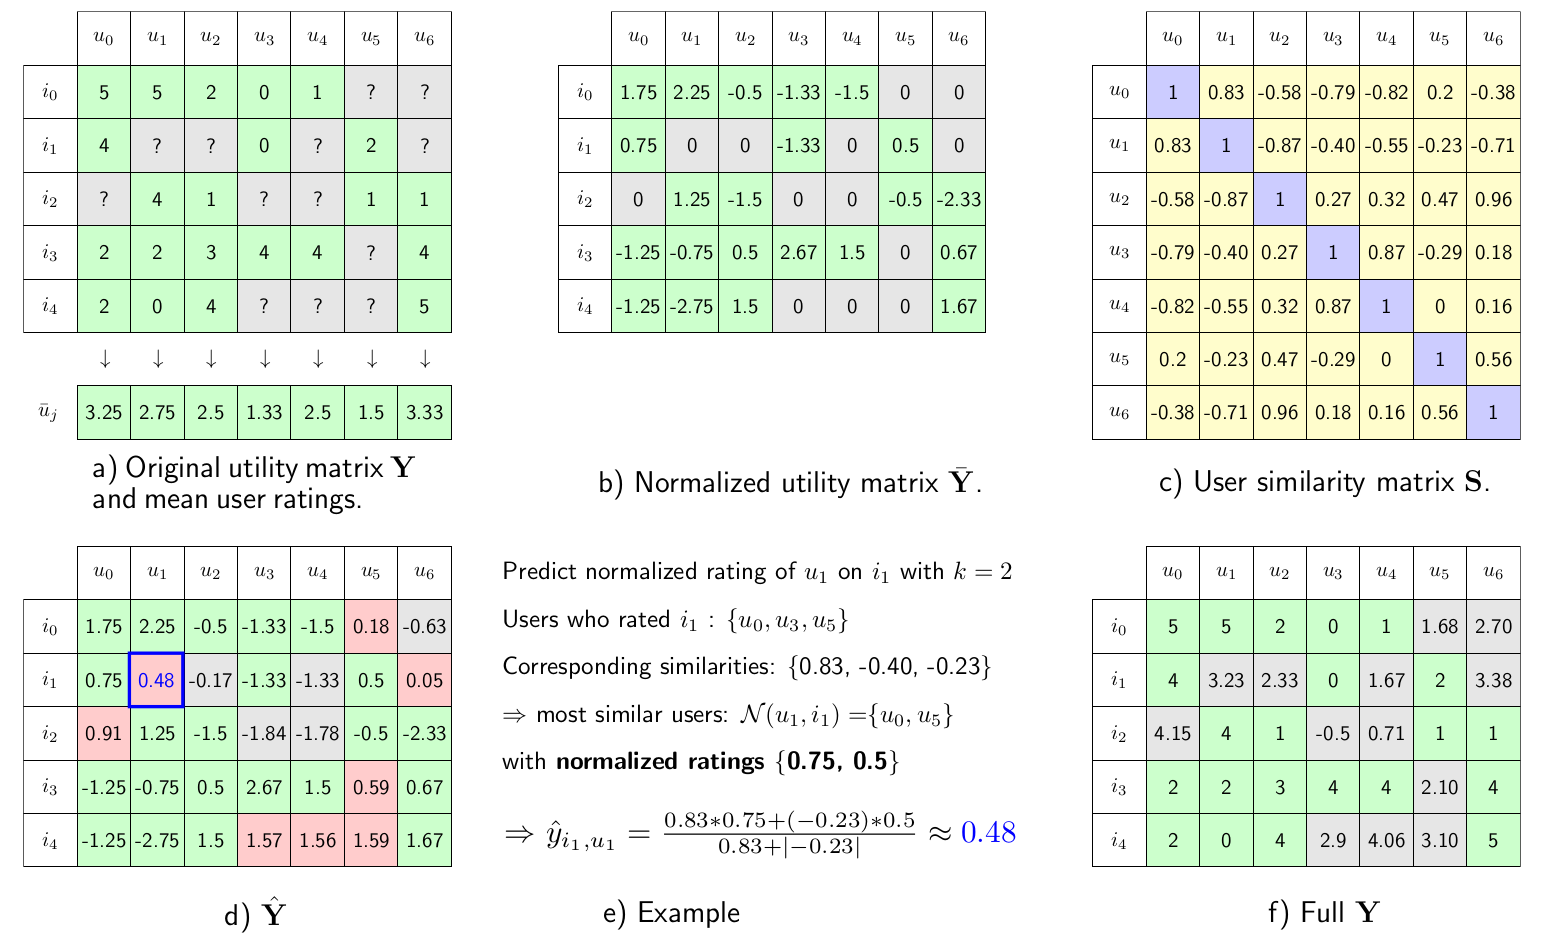
_Figure 2: Utility matrix with estimated values_

The last row in *Figure 2a* is the average of each user’s ratings. If we then subtract this average from each rating and replace the unknown values ​​with zero, we get a normalized utility matrix as shown in *Figure 2b*. This has several advantages:

- Subtracting the mean of each column will result in each column having both positive and negative values. Items with positive values ​​can be considered as items that users are more interested in than items with negative values. Items with a value of 0 are mainly suitable for items where the level of user interest is unknown.
- Technically, the dimensionality of the utility matrix is ​​very large with millions of users and items, and storing all these values ​​in a single matrix is ​​likely to run out of memory. It is observed that since the number of known ratings is usually a very small number compared to the size of the utility matrix, it is better to store this matrix as a sparse matrix, i.e. only storing non-zero values ​​and their positions. Therefore, it is better to replace the $‘?’$ with the value $‘0’$, meaning it is not yet known whether the user likes the item or not. This not only optimizes memory but also makes the calculation of the similarity matrix more efficient later.

After standardizing data, similarity function used usually is cosine similarity:

$$\text{cosine\_similarity}(\mathbf{u}_i, \mathbf{u}_j) = \cos(\mathbf{u}_i, \mathbf{u}_j) = \frac{\mathbf{u}_i^T\mathbf{u}_j}{||\mathbf{u}_i||_2||\mathbf{u}_j||_2}$$

where $\mathbf{u}_i, \mathbf{u}_j$ are two vectors representing two users $i$ and $j$.

The similarity level of two vectors is a real number in the range $[-1, 1]$. A value of $1$ represents that the two vectors are completely similar. The cosine function of an angle equal to $1$ means that the angle between the two vectors is $0$, meaning that the two vectors have the same direction and orientation. A cosine value of $-1$ represents that the two vectors are completely opposite, meaning that they have the same direction but different orientation. This means that if the behavior of two users is completely opposite, the similarity level between the two vectors is the lowest.

Continue observing row vectors corresponding to $u_0, u_1, u_2$ in *Figure 2c*, we will see several interesting things:

- $u_0$ is closer to $u_1$ and $u_5$ (positive similarity) than the other users. The high similarity between $u_0$ and $u_1$ is understandable because both of them tend to pay more attention to $i_0, i_1$, and $i_2$ than the other items. The closeness of $u_0$ to $u_5$ seems unreasonable at first because $u_5$ gives low ratings to items that $u_0$ gives high ratings to (*Figure 2a*); however, looking at the normalized utility matrix in *Figure 2b*, we see that this is reasonable because the only item that both of these users have provided information about is $i_1$ with positive corresponding values.
- $u_1$ is close to $u_0$ and far from the other users.
- $u_2$ is close to $u_3, u_4, u_5, u_6$ and far from the other users.

From this similarity matrix, we can cluster the users into two groups $(u_0, u_1)$ and $(u_2, u_3, u_4, u_5, u_6)$. Since this $\mathbf{S}$ matrix is ​​small, we can easily observe this; when the number of users is large, it is not feasible to determine by eye. The construction of the user clustering algorithm will be presented in the next chapter. An important note here is that when the number of users is large, the $\mathbf{S}$ matrix is ​​also very large and most likely there is not enough memory to store it, even if we only store more than half of the elements of this symmetric matrix. In such cases, for each user, we only need to calculate and store the result of one row of the similarity matrix, corresponding to the similarity between that user and the remaining users.

## Filling in the missing values ​​in the utility matrix

Similar to KNN, NBCF also uses the information of the k most recent users who rated this item to predict. The value to be filled in is usually defined as the weighted average of the normalized ratings. It should be noted that in KNN, the weights are determined based on the distance between two points, and these distances are non-negative numbers. In NBCF, the weights are determined based on the similarity between two users, which can be less than $0$. The common formula used to predict the number of stars that user $u$ rates item $i$ is

$$\hat{y}_{i, u} = \frac{\sum_{u_j \in \mathcal{N}(u, i)} \overline{y}_{i, u_j}\text{sim}(u, u_j)}{\sum_{u_j \in \mathcal{N}(u, i)} |\text{sim}(u, u_j)|}$$

in which:
- $\hat{y}_{i, u}$ is the predicted rating of user $u$ for item $i$.
- $\mathcal{N}(u, i)$ is the set of users who have rated item $i$.
- $\overline{y}_{i, u_j}$ is the normalized rating of user $u_j$ for item $i$.
- $\text{sim}(u, u_j)$ is the similarity between user $u$ and user $u_j$.

An example of computing the normalized rating of $u_1$ for $i_1$ is given in *Figure 2e* with the number of nearest neighbors being $k = 2$. The steps are as follows:

1. Determine the users who rated $i_1$, they are $u_0, u_3, u_5$.
2. The similarity levels of u1 with these users are $\{0.83, −0.40, −0.23\}$, respectively. The two $(k = 2)$ largest values ​​are $0.83$ and $−0.23$ for $u_0$ and $u_5$, respectively.
3. Determine the (normalized) ratings of $u_0$ and $u_5$ for $i_1$, we get two values, $0.75$ and $0.5$, respectively.
4. Predict the result

$$\hat{y}_{i_1, u_1} = \frac{0.75 \times 0.83 + 0.5 \times (-0.23)}{0.83 + |0.23|} \approx 0.48$$

### Disadvantages of user-user collaborative filtering

- When the number of users is much larger than the number of items (which often happens), the size of the similarity matrix is ​​very large (each dimension of this matrix has the same number of elements as the number of users). Storing a matrix with such a large size is often not feasible.
- The utility matrix $\mathbf{Y}$ is usually very sparse, meaning that only a small proportion of the elements are known. With a very large number of users compared to the number of items, many columns of this matrix have very few, or even no, non-zero elements because users are often lazy to rate items. Therefore, once that user changes their previous ratings or rates more items, the average of the ratings as well as the corresponding normalized vector for this user changes a lot. As a result, the calculation of the similarity matrix, which is memory- and time-consuming, also needs to be redone.

### Another approach

Instead of finding similarity between users, we can find similarity between items. From there, if a user likes an item, the system should suggest similar items to that user. This has some advantages:

- When the number of items is smaller than the number of users, the similarity matrix has a smaller size, which makes the storage and calculation in the following steps more efficient.
- Also assume that the number of items is smaller than the number of users. Since the total number of ratings is constant, the average number of items rated by a user will be less than the average number of users who rated an item. In other words, if the utility matrix has fewer rows than columns, the average number of known elements in each row will be more than the average number of known elements in each column. Consequently, information about each item is more than information about each user, so calculating similarity between rows is also more reliable. Furthermore, the mean of each row also changes less when a few more reviews are added. Thus, updating the similarity matrix can be done less frequently.

This approach is called item-item collaborative filtering (item-item CF). When the number of items is less than the number of users, this method is preferred.

## Item-item collaborative filtering

Computationally, item-item CF can be obtained from user-user CF by transposing the utility matrix, and treating the item as inversely evaluating the user. After calculating the final result, we transpose it again to obtain the result.

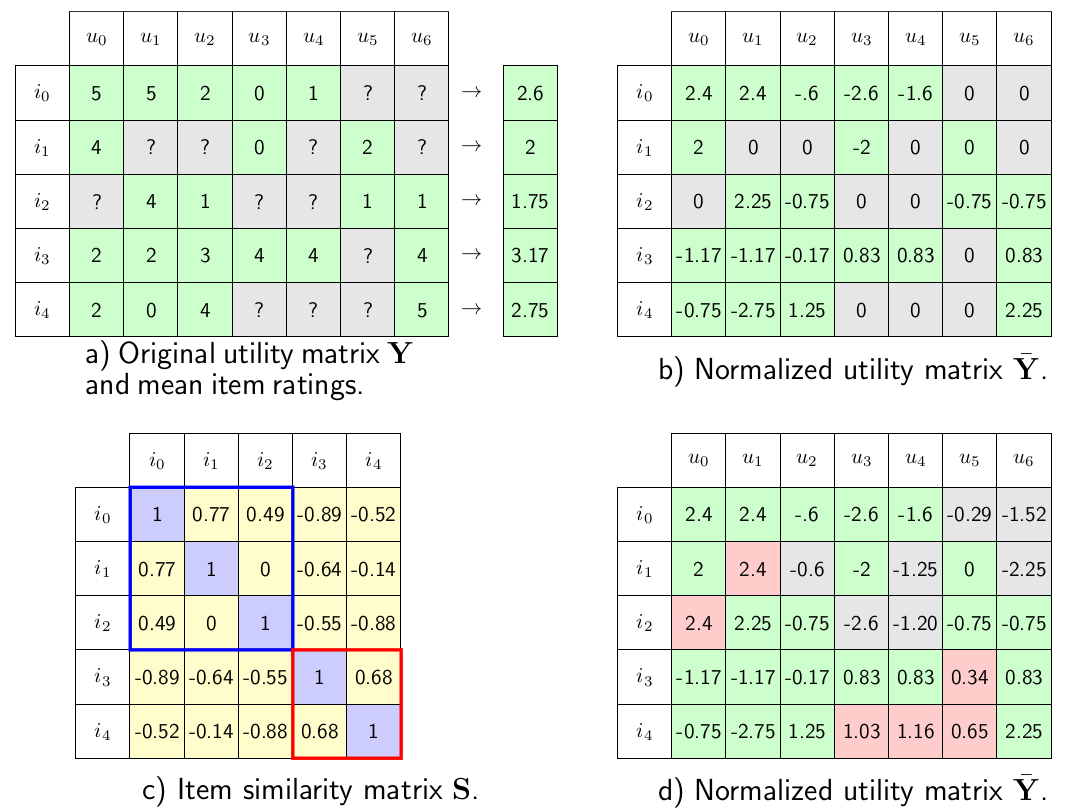

_Figure 3: Utility matrix and its transpose_

An interesting point in the similarity matrix in *Figure 3c* is that the elements in the two blue and red squares are non-negative numbers, the elements outside are negative numbers. This shows that the items can be divided into two distinct groups. Thus, we have unintentionally performed item clustering. This will help a lot in the prediction later because similar items are likely to be classified into one group. The final result of choosing which item to recommend to each user is shown by the red boxes in *Figure 3d*. It seems that this result is more reasonable because from the utility matrix, we see that there are two groups of users who like two different groups of items.

Note that the `sklearn` library does not yet support modules for recommendation systems. Another good library on python that readers can refer to is [`surprise`](http://surpriselib.com/).

## Python programming

In this lesson, I will program in Object Oriented way for `CF` class. This class is used for both User-user and Item-item CF. First, we will experiment with the small example in the lesson, then apply it to the problem with MovieLens database.

Below is the `ex.dat` file describing the known data for the example. The order of the three columns is `user_id`, `item_id`, and `rating`. For example, the first row means `u_0` rates `i_0` number of stars is $5$:

```md
0 0 5
0 1 4
0 3 2
0 4 2
1 0 5
1 2 4
1 3 2
1 4 0
2 0 2
2 2 1
2 3 3
2 4 4
3 0 0
3 1 0
3 3 4
4 0 1
4 3 4
5 1 2
5 2 1
6 2 1
6 3 4
6 4 5
```

When working with Item-item CF, we just need to swap the positions of the first two columns to get the transpose matrix.

In [37]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

class CF(object):
    def __init__(self, Y_data, k, dist_func = cosine_similarity, uuCF = 1):
        self.uuCF = uuCF # user-user (1) or item-item (0) CF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]]
        self.k = k # number of neighbor points
        self.dist_func = dist_func
        self.Ybar_data = None
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1 
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1

    def add(self, new_data):
        """
        Update Y_data matrix when new ratings come.
        """
        self.Y_data = np.concatenate((self.Y_data, new_data), axis = 0)

    def normalize_Y(self):
        users = self.Y_data[:, 0] # all users - first col of the Y_data
        self.Ybar_data = self.Y_data.copy()
        self.mu = np.zeros((self.n_users,)) # a list of users' average ratings

        for n in range(self.n_users):
            # row indices of rating done by user n
            # since indices need to be integers, we need to convert
            ids = np.where(users == n)[0].astype(np.int32)

            # indices of all ratings associated with user n
            item_ids = self.Y_data[ids, 1]

            # and the corresponding ratings 
            ratings = self.Y_data[ids, 2]

            # take mean
            self.mu[n] = np.mean(ratings) if ids.size > 0 else 0
            # normalize
            self.Ybar_data[ids, 2] = ratings - self.mu[n]

        ################################################
        # form the rating matrix as a sparse matrix. Sparsity is important 
        # for both memory and computing efficiency. For example, if #user = 1M, 
        # #item = 100k, then shape of the rating matrix would be (100k, 1M), 
        # you may not have enough memory to store this. Then, instead, we store 
        # nonzeros only, and, of course, their locations.
        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2], (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.tocsr() 
        # some versions of scipy create COO matrix (which is good for constructing, but bad for computation) - convert it to CSR format
        # CSR is good for computation, LIL is good for construction

    def similarity(self):
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)

    def fit(self):
        """
        Normalize data and calculate similarity matrix again (after
        some few ratings added)
        """
        self.normalize_Y()
        self.similarity() 
        
    def predicting(self, u, i, normalized=1):
        """
        predict the rating of user u for item i (normalized)
        """
        # Step 1: find all users who rated i
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)

        # Step 2: find similarity btw the current user and others who already rated i
        sim = self.S[u, users_rated_i]

        # Step 3: find the k most similarity users
        nns = np.argsort(sim)[-self.k:] 
        # `np.argsort` sorts in ascending order and returns the indices of the sorted items, so we need to take the last k elements
        # and the corresponding similarity levels
        nearest_s = sim[nns] 

        # the corresponding ratings
        r = self.Ybar[i, users_rated_i[nns]]

        if normalized:
            # add a small number, for instance, 1e-8, to avoid dividing by 0
            return (r * nearest_s)[0] / (np.abs(nearest_s).sum() + 1e-8)
        return (r * nearest_s)[0] / (np.abs(nearest_s).sum() + 1e-8) + self.mu[u]
    
    def prediction(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        if self.uuCF: return self.predicting(u, i, normalized)
        return self.predicting(i, u, normalized)

    def recommend(self, u, normalized = 1):
        """
        Determine all items should be recommended for user u (uuCF =1)
        or all users who might have interest on item u (uuCF = 0).
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which 
        have not been rated by u yet. 
        """
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist()              
        recommended_items = []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.predicting(u, i)
                if rating > 0: recommended_items.append(i)
        
        return recommended_items
    
    def print_recommendation(self):
        """
        Print all items which should be recommended for each user 
        """
        print('Recommendation: ')
        for u in range(self.n_users):
            recommended_items = self.recommend(u)
            if self.uuCF:
                print('\tRecommend item(s):', recommended_items, 'to user', u)
            else: 
                print('\tRecommend item', u, 'to user(s) : ', recommended_items)

### Applying to the example

In [38]:
r_cols = ['user_id', 'item_id', 'rating']
ratings = pd.read_csv('Datasets/ex.dat', sep = ' ', names = r_cols, encoding='latin-1')
Y_data = ratings.to_numpy()

rs = CF(Y_data, k = 2, uuCF = 1)
rs.fit()

rs.print_recommendation()

Recommendation: 
	Recommend item(s): [2] to user 0
	Recommend item(s): [1] to user 1
	Recommend item(s): [] to user 2
	Recommend item(s): [4] to user 3
	Recommend item(s): [4] to user 4
	Recommend item(s): [0, 3, 4] to user 5
	Recommend item(s): [1] to user 6


In [39]:
rs = CF(Y_data, k = 2, uuCF = 0)
rs.fit()

rs.print_recommendation()

Recommendation: 
	Recommend item 0 to user(s) :  []
	Recommend item 1 to user(s) :  [1]
	Recommend item 2 to user(s) :  [0]
	Recommend item 3 to user(s) :  [5]
	Recommend item 4 to user(s) :  [3, 4, 5]


### Applying to the MovieLens database

In [41]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_base = pd.read_csv('Datasets/ml-100k/ub.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('Datasets/ml-100k/ub.test', sep='\t', names=r_cols, encoding='latin-1')

rate_train = ratings_base.to_numpy()
rate_test = ratings_test.to_numpy()

# indices start from 0
rate_train[:, :2] -= 1
rate_test[:, :2] -= 1

In [45]:
# user-user CF
rs = CF(rate_train, k = 30, uuCF = 1)
rs.fit()

n_tests = rate_test.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs.prediction(rate_test[n, 0], rate_test[n, 1], normalized = 0)
    SE += (pred - rate_test[n, 2])**2 

RMSE = np.sqrt(SE / n_tests)
print('User-user CF, RMSE =', RMSE)

User-user CF, RMSE = 0.9951981100882598


In [47]:
# item-item CF
rs = CF(rate_train, k = 30, uuCF = 0)
rs.fit()

n_tests = rate_test.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs.prediction(rate_test[n, 0], rate_test[n, 1], normalized = 0)
    SE += (pred - rate_test[n, 2])**2 

RMSE = np.sqrt(SE / n_tests)
print('Item-item CF, RMSE =', RMSE)

Item-item CF, RMSE = 0.9867912132705384


Therefore, in this case, item-item CF gives better results, even when the number of items (1682) is much larger than the number of users (943). For other problems, we should try both on a validation set and choose the method that gives better results. We can also change the neighborhood size `k` to other values ​​and compare the results.